# 1. Import Libraries

In [1]:
# data management libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# interactive visualizarion libaries
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# scikit learn clustering library
from sklearn.cluster import KMeans
# import the silhouette metric
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from matplotlib import style

#always :)
style.use("dark_background") 

# 2. Read Data 

In [2]:
df = pd.read_csv('data/transactions.csv')
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [3]:
# check for missing values
df.isnull().sum()

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

In [4]:
df.dtypes

step             int64
customer        object
age             object
gender          object
zipcodeOri      object
merchant        object
zipMerchant     object
category        object
amount         float64
fraud            int64
dtype: object

In [5]:
df.describe()

,step,amount,fraud
count,594643.000000,594643.000000,594643.000000
mean,94.986827,37.890135,0.012108
std,51.053632,111.402831,0.109369
min,0.000000,0.000000,0.000000
25%,52.000000,13.740000,0.000000
50%,97.000000,26.900000,0.000000
75%,139.000000,42.540000,0.000000
max,179.000000,8329.960000,1.000000


# 3. EDA

**Features:** 
- **Step:**  
    Represents the day when the transaction happened. There is a total of 180 steps, so the data runs for six months. This field will be **dropped** since its non significant.
- **Customer:**  
    Represents the unique ID of the person who initialized the transaction. It is formed by the letter `C`, followed by a unique sequence of 10 numbers. There is a total of 4,109 unique customers available in the dataset, so this will also be dropped, since the algorithm shouldn't be biased against any customer id.
- **Age:**  
    This variable is split into age intervals, starting from 0 to 6, and the letter `U` which stands for Unknown. Age is Unknown only for transactions that have the gender equal to Enterprise. The coding for the numbers is:  
    - `0`: less than 18 years old  
    - `1`: between 19 and 25 years old  
    - `2`: between 26 and 35 years old  
    - `3`: between 36 and 45 years old  
    - `4`: between 46 and 55 years old  
    - `5`: between 56 and 65 years old  
    - `6`: older than 65 years old  
    - `7`: `U` will be mapped to `7` for numerical encoding purposes. 
- **Gender:**  
    This variable is coded as `F` for Female, `M` for Male, `E` for Enterprise, and `U` for Unknown. The Unknown group has around 170 customers aged in groups 1, 2, and 3. Unkown gender inputs will be dropped, because they are considered as incomplete entries.
- **Merchant:**  
    Represents the unique ID of the party which receives the transaction. Similar to customer ID, the sequence is formed by the letter `M`, followed by a series of 9 numbers. There is a total of 50 unique merchants in the dataset. This column will also be dropped, since the algorithm shouldn't be biased based on merchant id either.
- **Category:**  
    There are 15 unique categories that label the general type of the transaction:  
    `transportation`, `food`, `health`, `wellness and beauty`, `fashion`, `bars and restaurant`, `hyper`, `sports and toys`, `tech`, `home`, `hotel services`, `other services`, `contents`, `travel`, `leisure`.  
- **Amount:**  
    Represents the value of the transaction. There are only 52 values equal to 0 and no negative values.  
- **Fraud:**  
    A flag column coded with `0` if the transaction was clean and with `1` if the transaction was fraudulent.  
- **zipcodeOri** and **zipMerchant:**  
    These two features will be **removed** from the dataset, as they contained a constant value of `28007`, which is a postal code in Ansonville, North Carolina, United States. 

### Preprosessing

In [4]:
# drop the columns that are not significant for clustering
df = df.drop(columns=['step', 'customer', 'merchant', 'zipcodeOri', 'zipMerchant'])

#remove 'es_' from the 'category' column
df['category'] = df['category'].str.replace('es_', '', regex=False)

# remove special symbols from all columns
df = df.replace("^.|.$", '', regex=False)

#drop rows that have 'U' in 'gender' column
df = df[df['gender'] != '\'U\'']

# replace 'U' with '7' in age and convert age from str to int
df['age'] = df['age'].replace('\'U\'', '7').str.strip("'\"").astype(int)

# encode the gender/category columns using one-hot encoding keep the original columns
gender = df['gender']
category = df['category']
df = pd.get_dummies(df, columns=['gender', 'category'])
df['gender_original'] = gender
df['category_original'] = category

In [5]:
df.head()

,age,amount,fraud,gender_'E',gender_'F',gender_'M',category_'barsandrestaurants',category_'contents',category_'fashion',category_'food',...,category_'hyper',category_'leisure',category_'otherservices',category_'sportsandtoys',category_'tech',category_'transportation',category_'travel',category_'wellnessandbeauty',gender_original,category_original
0,4,4.55,0,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,'M','transportation'
1,2,39.68,0,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,'M','transportation'
2,4,26.89,0,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,'F','transportation'
3,3,17.25,0,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,'M','transportation'
4,5,35.72,0,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,'M','transportation'


### Plotting

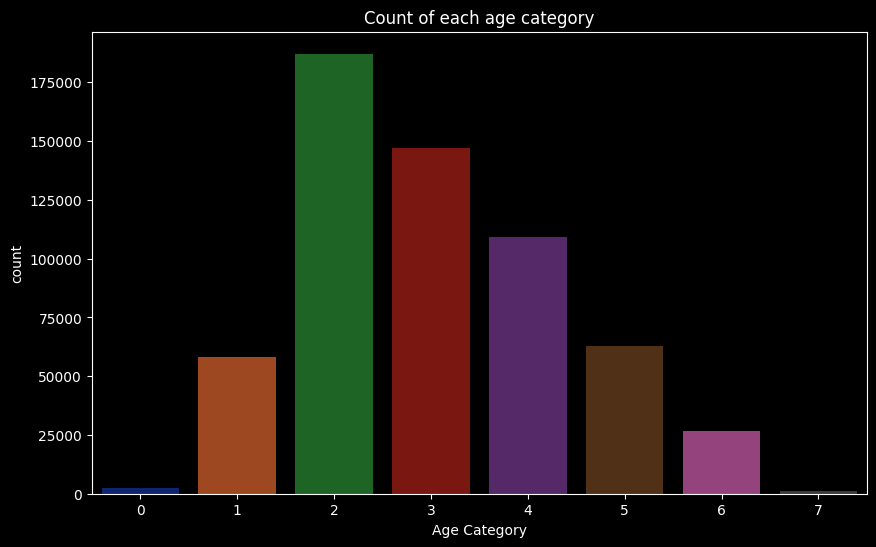

In [6]:
#plot count of each age category
plt.figure(figsize=(10, 6));
sns.countplot(data=df, x='age', hue='age', palette='dark', legend=False);
plt.title('Count of each age category')
plt.xlabel('Age Category')
plt.show()

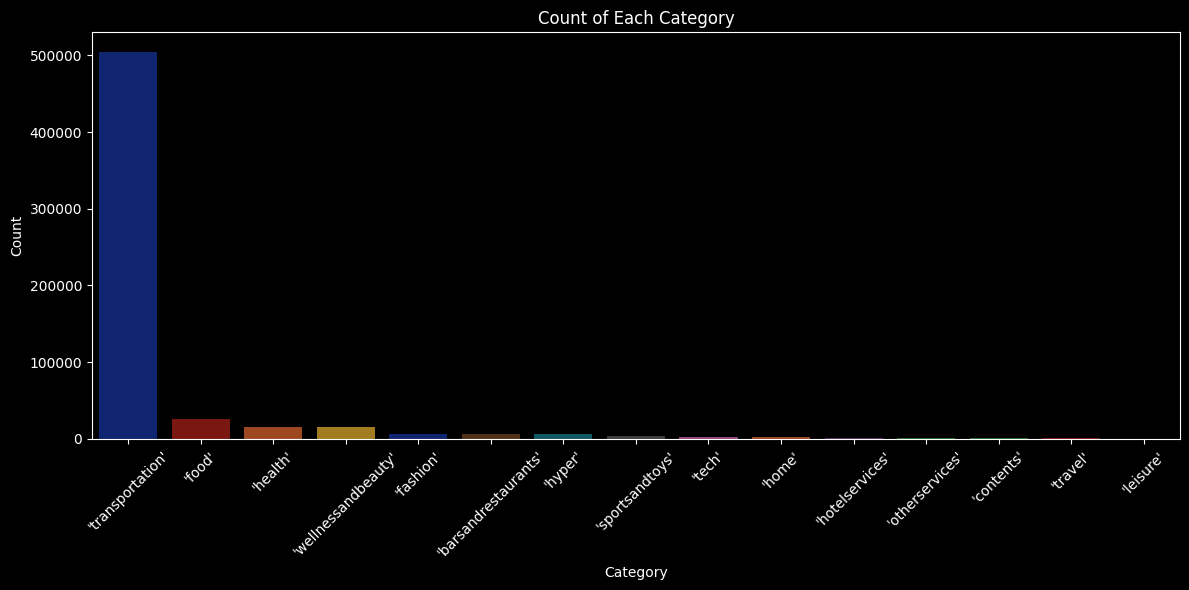

In [7]:
#plot count of each category
plt.figure(figsize=(12, 6))
sns.countplot(data=df, 
    x='category_original', 
    hue='category_original', 
    order=df['category_original'].value_counts().index, 
    palette='dark', 
    dodge=False)
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Count of Each Category')
plt.tight_layout()
plt.show()

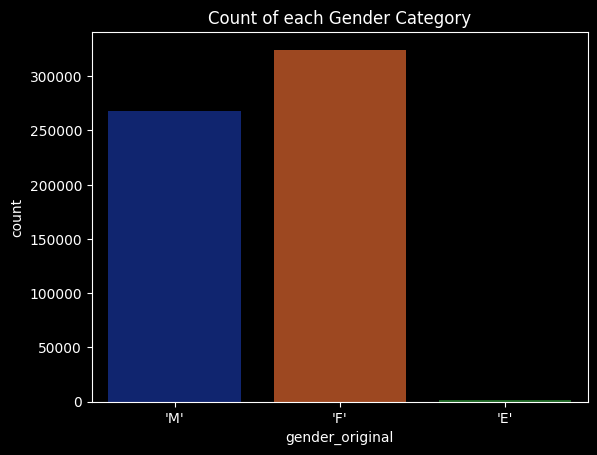

In [8]:
#plot count of each gender
sns.countplot(data=df, x='gender_original', hue='gender_original', palette='dark', legend=False);
plt.title('Count of each Gender Category')
plt.show()

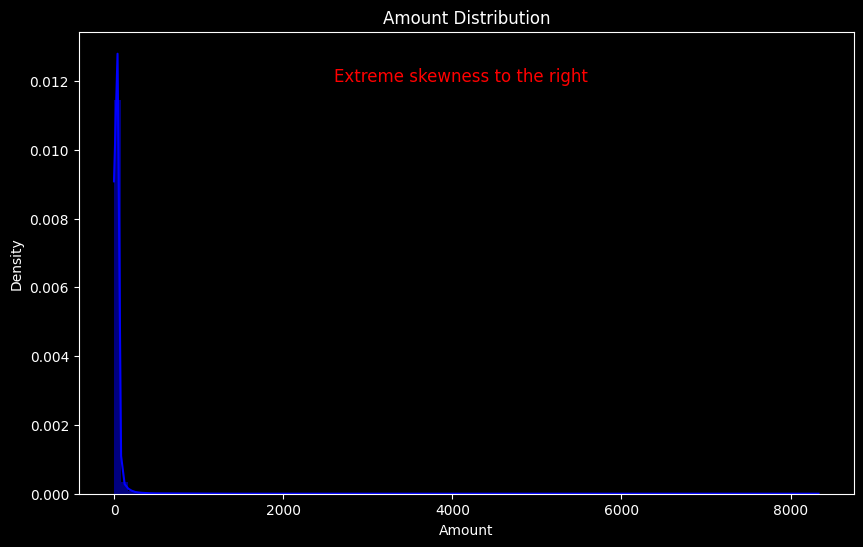

In [9]:
# plot the amount distribution
plt.figure(figsize=(10, 6))
sns.histplot(x=df['amount'], kde=True, color='blue', bins=100, stat='density', linewidth=0, alpha=0.5)
plt.title('Amount Distribution')
plt.xlabel('Amount')
plt.text(x=2600, y=0.012, s='Extreme skewness to the right', fontsize=12, color='red')
plt.show()

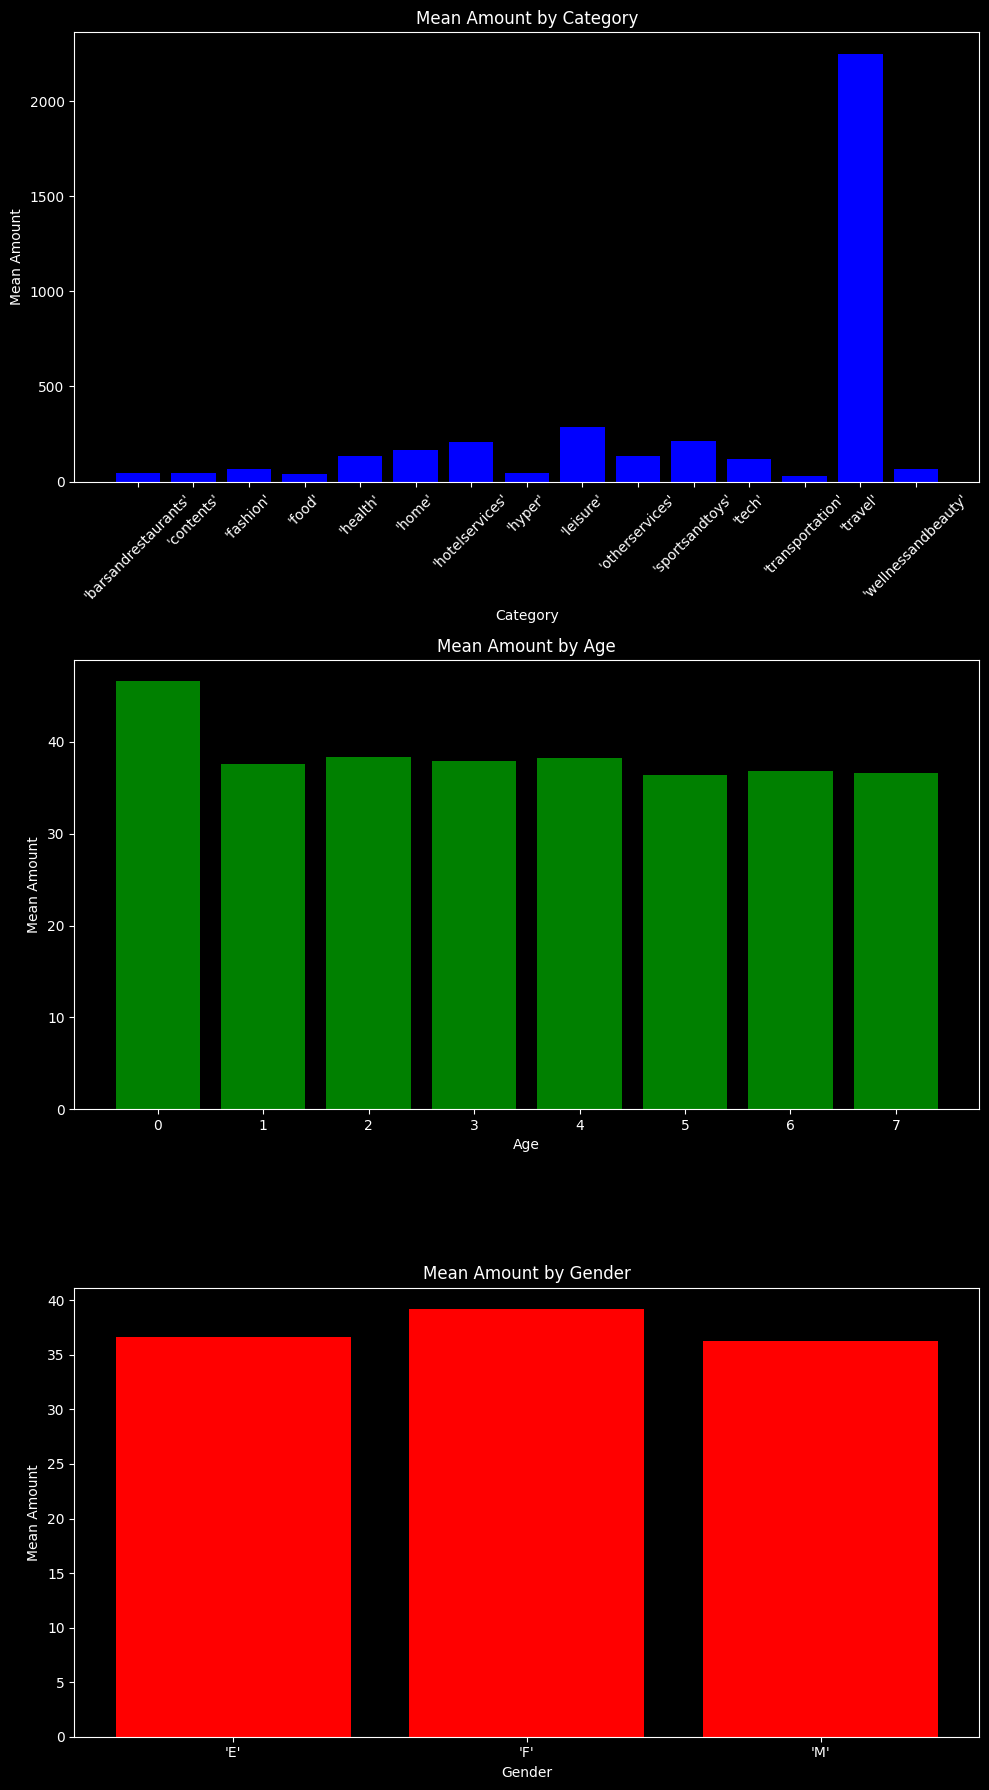

In [10]:
plt.figure(figsize=(10, 18))
plt.subplot(3, 1, 1)
plt.bar(df.groupby('category_original')['amount'].describe().index, df.groupby('category_original')['amount'].describe()['mean'], color='blue')
plt.title('Mean Amount by Category')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.ylabel('Mean Amount') 
plt.subplot(3, 1, 2)
plt.bar(df.groupby('age')['amount'].describe().index, df.groupby('age')['amount'].describe()['mean'], color='green')
plt.title('Mean Amount by Age')
plt.xlabel('Age')
plt.ylabel('Mean Amount')
plt.subplot(3, 1, 3)
plt.bar(df.groupby('gender_original')['amount'].describe().index, df.groupby('gender_original')['amount'].describe()['mean'], color='red')
plt.title('Mean Amount by Gender')
plt.xlabel('Gender')
plt.ylabel('Mean Amount')
plt.tight_layout()
plt.show()


#### Fraud Plots

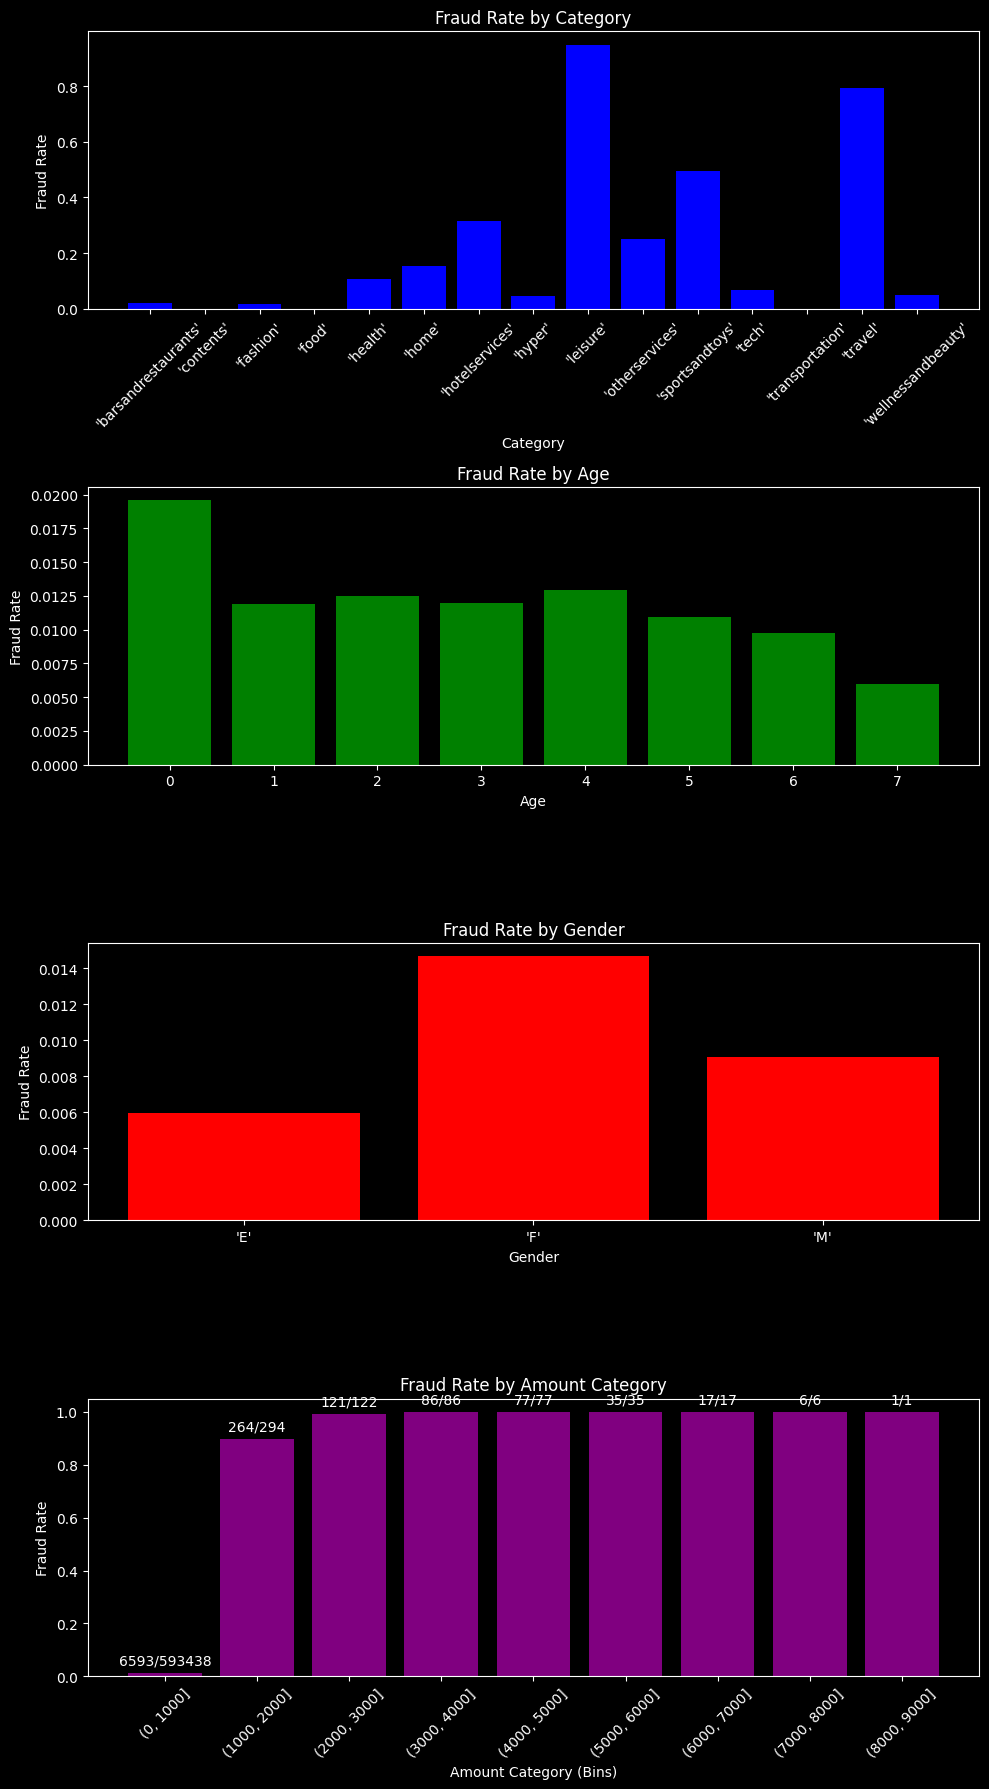

In [11]:
# plot the frauds distribution in corelation with the amount / gender / age / category
plt.figure(figsize=(10, 18))
plt.subplot(4, 1, 1)
plt.bar(df.groupby('category_original')['fraud'].describe().index, df.groupby('category_original')['fraud'].describe()['mean'], color='blue')
plt.title('Fraud Rate by Category')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.ylabel('Fraud Rate')
plt.subplot(4, 1, 2)
plt.bar(df.groupby('age')['fraud'].describe().index, df.groupby('age')['fraud'].describe()['mean'], color='green')
plt.title('Fraud Rate by Age')
plt.xlabel('Age')
plt.ylabel('Fraud Rate')
plt.subplot(4, 1, 3)
plt.bar(df.groupby('gender_original')['fraud'].describe().index, df.groupby('gender_original')['fraud'].describe()['mean'], color='red')
plt.title('Fraud Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Fraud Rate')
plt.subplot(4, 1, 4)

# plot the fraud rate by amount, using bins of 1000

amount_bins = pd.cut(df['amount'], bins=range(0, int(df['amount'].max()) + 1000, 1000))
fraud_rate_by_amount = df.groupby(amount_bins,observed=False)['fraud'].mean()
fraud_counts_by_amount = df.groupby(amount_bins, observed=False)['fraud'].sum()
total_counts_by_amount = df.groupby(amount_bins, observed=False)['fraud'].count()

bars = plt.bar(fraud_rate_by_amount.index.astype(str), fraud_rate_by_amount.values, color='purple')

# Annotate each bar with the count of frauds and total inputs
for bar, bin_label in zip(bars, fraud_rate_by_amount.index):
    height = bar.get_height()
    fraud_count = fraud_counts_by_amount[bin_label]
    total_count = total_counts_by_amount[bin_label]
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02,
             f"{fraud_count}/{total_count}",
             ha='center', va='bottom', fontsize=10)
plt.bar(fraud_rate_by_amount.index.astype(str), fraud_rate_by_amount.values, color='purple')
plt.xticks(rotation=45)
plt.title('Fraud Rate by Amount Category')
plt.xlabel('Amount Category (Bins)')
plt.ylabel('Fraud Rate')
plt.tight_layout()
plt.show()

# 4. Clustering

In [12]:
# select X as the features for clustering (everything except the fraud column)
X = df.drop(columns=['fraud','gender_original','category_original']).copy()

In [13]:
#enumerate the categorical columns for plotting
for col in ['gender_original','category_original']:
    df[col+'_enum'] = pd.Categorical(df[col]).codes

df.head()

,age,amount,fraud,gender_'E',gender_'F',gender_'M',category_'barsandrestaurants',category_'contents',category_'fashion',category_'food',...,category_'otherservices',category_'sportsandtoys',category_'tech',category_'transportation',category_'travel',category_'wellnessandbeauty',gender_original,category_original,gender_original_enum,category_original_enum
0,4,4.55,0,False,False,True,False,False,False,False,...,False,False,False,True,False,False,'M','transportation',2,12
1,2,39.68,0,False,False,True,False,False,False,False,...,False,False,False,True,False,False,'M','transportation',2,12
2,4,26.89,0,False,True,False,False,False,False,False,...,False,False,False,True,False,False,'F','transportation',1,12
3,3,17.25,0,False,False,True,False,False,False,False,...,False,False,False,True,False,False,'M','transportation',2,12
4,5,35.72,0,False,False,True,False,False,False,False,...,False,False,False,True,False,False,'M','transportation',2,12


In [14]:
# empty list to contain the score of each cluster.
clustering_score = []

# Get the inertia score for 10 models, from 1 cluster to 10.
for clusters_number in range(1, 11):
    # initiate and customize algo
    model = KMeans(n_clusters=clusters_number, random_state=0)
    # fit algo to the data
    model.fit(X)
    # inertia_ = Sum of squared distances of samples to their closest cluster center.
    # this is the Within Clusters Sum of Squares metric, WCSS
    clustering_score.append(model.inertia_)

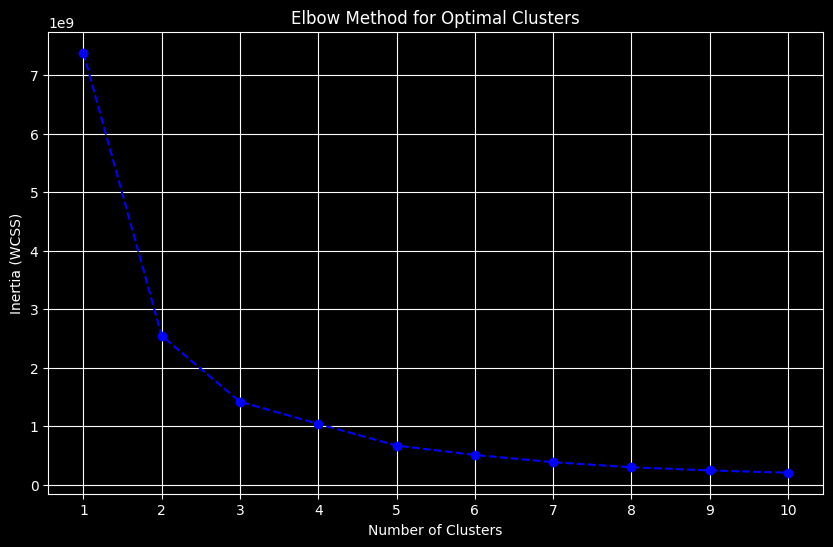

In [15]:
# plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), clustering_score, marker='o', linestyle='--', color='blue')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (WCSS)')
plt.xticks(range(1, 11))
plt.grid()


In [16]:
# This takes too long to run, so I commented it out.
# Dont try this at home!

# #create empty list to store score
# silhouette_scores_list = []

# # loop from 2 to 4 clusters:
# for clusters_number in range(2, 5):  # Silhouette starts from 2 clusters.
#     # initiate and customize algo
#     model = KMeans(n_clusters=clusters_number, random_state=0)
#     # fit algo to the data
#     clusters = model.fit_predict(X)
#     # calculate silhouette score for each number of clusters
#     silhouette_metric_score = silhouette_score(X, clusters)
#     # append each score to the list
#     silhouette_scores_list.append(silhouette_metric_score)
#     print(
#         f"For clusters={clusters_number}, the average silhouette_score is: {silhouette_metric_score}")

We can see that **2 or 3 clusters** is the "Elbow" point

In [28]:
def plot_results(df_pca):
    # Plot 1: 3D Scatter Plot of Clusters
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(
        df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], 
        c=df_pca['cluster'], cmap='viridis', alpha=0.7
    )
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)
    ax.set_title('3D Scatter Plot of Clusters')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.show()

    # Plot 2: 3D Scatter Plot with Fraud and Non-Fraud
    fig = plt.figure(figsize=(10, 10))
    # Add the fraud column to the df_pca for visualization
    df_pca['fraud'] = df['fraud'].values
    # Separate fraud and non-fraud entries
    fraud_entries = df_pca[df_pca['fraud'] == 1]
    non_fraud_entries = df_pca[df_pca['fraud'] == 0]

    # Plot non-fraud entries
    ax = fig.add_subplot(111, projection='3d')
    scatter_non_fraud = ax.scatter(
        non_fraud_entries['PC1'], non_fraud_entries['PC2'], non_fraud_entries['PC3'], 
        c=non_fraud_entries['cluster'], cmap='viridis', alpha=0.7, label='Non-Fraud'
    )

    # Plot fraud entries with a different marker
    scatter_fraud = ax.scatter(
        fraud_entries['PC1'], fraud_entries['PC2'], fraud_entries['PC3'], 
        c='red', alpha=0.7, label='Fraud', marker='^'
    )

    # Add legends
    legend1 = ax.legend(*scatter_non_fraud.legend_elements(), title="Clusters")
    ax.add_artist(legend1)
    ax.legend(loc='upper left')
    ax.set_title('3D Scatter Plot of Fraud and Non-Fraud')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.show()

    # Plot 3: Fraud Percentage in Each Cluster with Counts
    fraud_counts = df_pca.groupby('cluster')['fraud'].sum()
    total_counts = df_pca['cluster'].value_counts()
    fraud_percentage = (fraud_counts / total_counts) * 100

    plt.figure(figsize=(10, 6))
    bars = plt.bar(fraud_percentage.index, fraud_percentage.values, color='blue', alpha=0.7)

    # Annotate each bar with the count and percentage
    for bar, cluster in zip(bars, fraud_percentage.index):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 1,
                 f"{int(fraud_counts[cluster])}/{int(total_counts[cluster])}\n({fraud_percentage[cluster]:.2f}%)",
                 ha='center', va='bottom', fontsize=10)

    plt.title('Fraud Percentage in Each Cluster with Counts')
    plt.xlabel('Cluster')
    plt.ylabel('Fraud Percentage (%)')
    plt.xticks(fraud_percentage.index, [f'Cluster {i}' for i in fraud_percentage.index])
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()  


Apply PCA for 3D visualization.
Note that the fitting is conducted **on the initial df**, PCA df is used only for plotting.

In [18]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
# create a DataFrame with the PCA components and the cluster labels
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3']) 

## 2 clusters

In [19]:
y_pred = KMeans(n_clusters=2, n_init='auto').fit_predict(X)
# df_pca['cluster'] = y_pred
df['cluster'] = y_pred
df_pca['cluster'] = y_pred

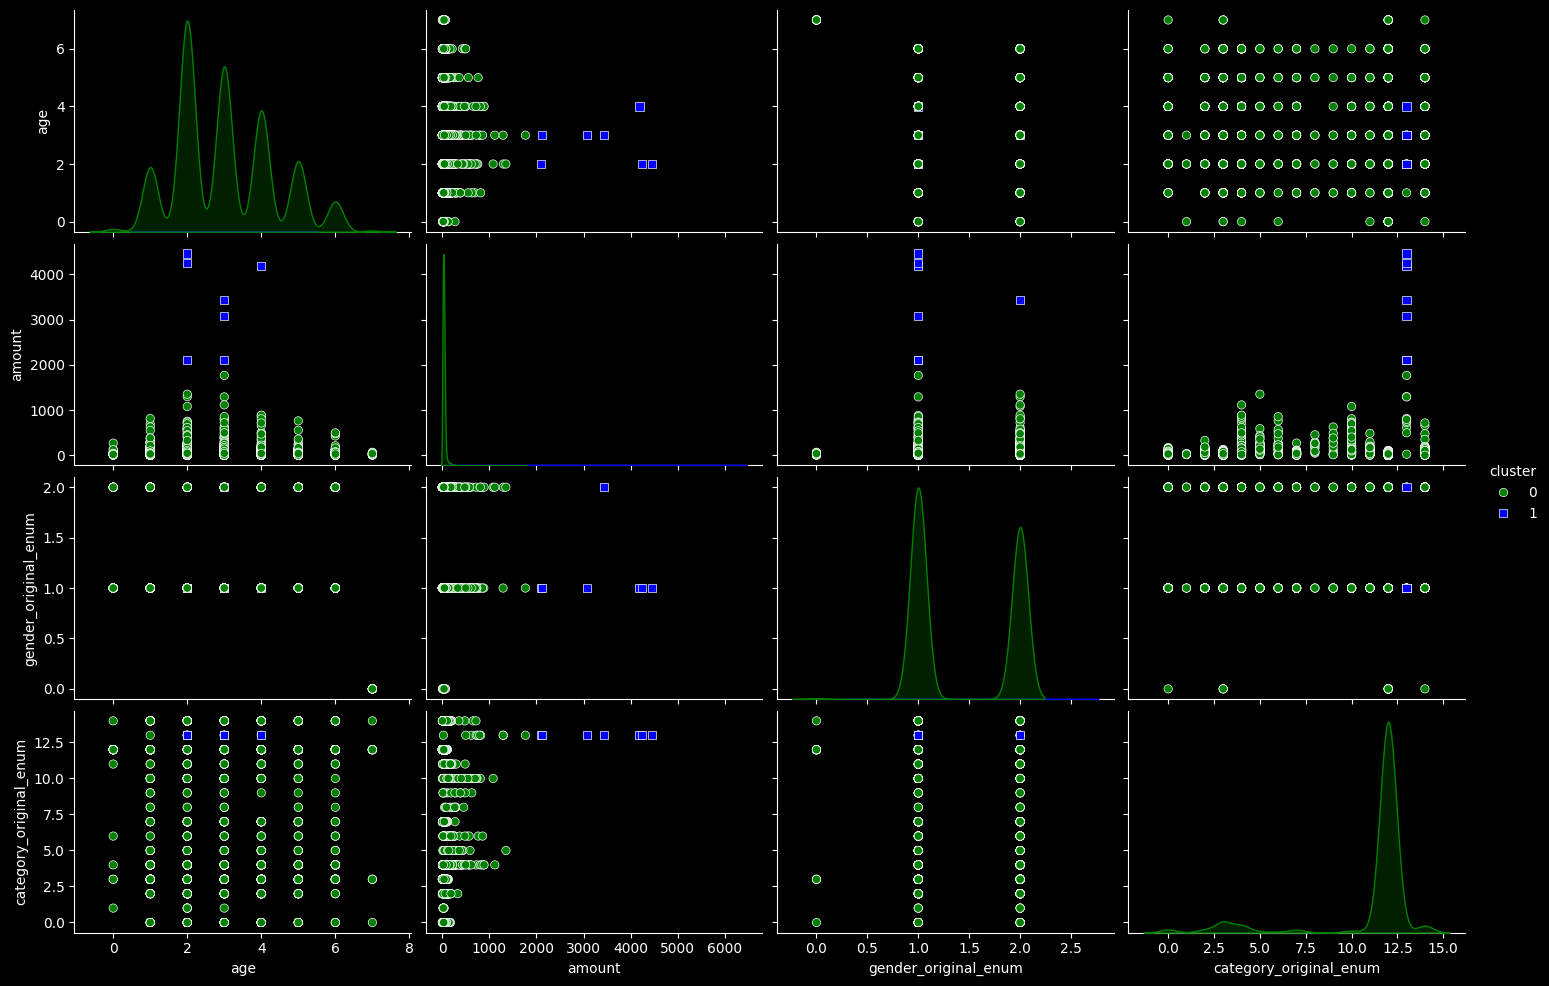

In [20]:
one_hot_col_names = [col for col in df.columns if (col.startswith('gender_') or col.startswith('category_')) and not col.endswith('original_enum')]
sns.pairplot(df.drop(columns=['fraud'] + one_hot_col_names).sample(10000), hue='cluster', palette=['green', 'blue'], diag_kind='kde', markers=['o', 's'], height=2.5, aspect=1.5)
plt.show()

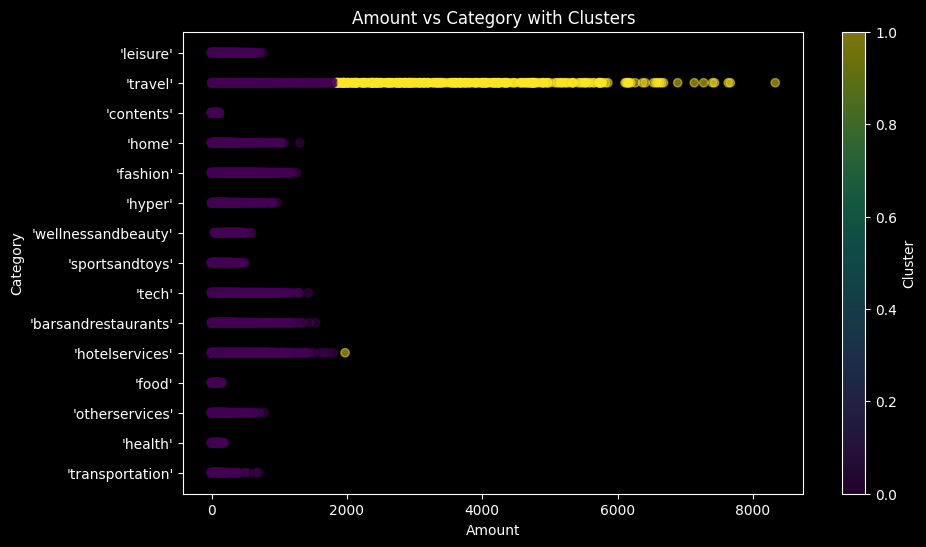

In [24]:
#plot amount vs category with clusters 
plt.figure(figsize=(10, 6))
plt.scatter(df['amount'], df['category_original_enum'], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.title('Amount vs Category with Clusters')
plt.xlabel('Amount')
plt.ylabel('Category')
plt.yticks(range(len(df['category_original'].unique())), df['category_original'].unique())
plt.colorbar(label='Cluster')
plt.show()

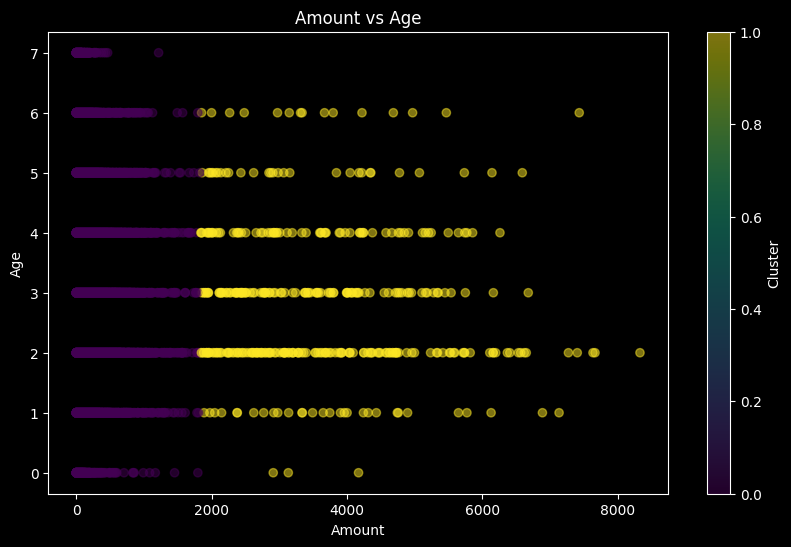

In [25]:
# plot amount vs age with clusters
plt.figure(figsize=(10, 6))
plt.scatter(df['amount'], df['age'], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.title('Amount vs Age')
plt.xlabel('Amount')
plt.ylabel('Age')
plt.colorbar(label='Cluster')
plt.show()

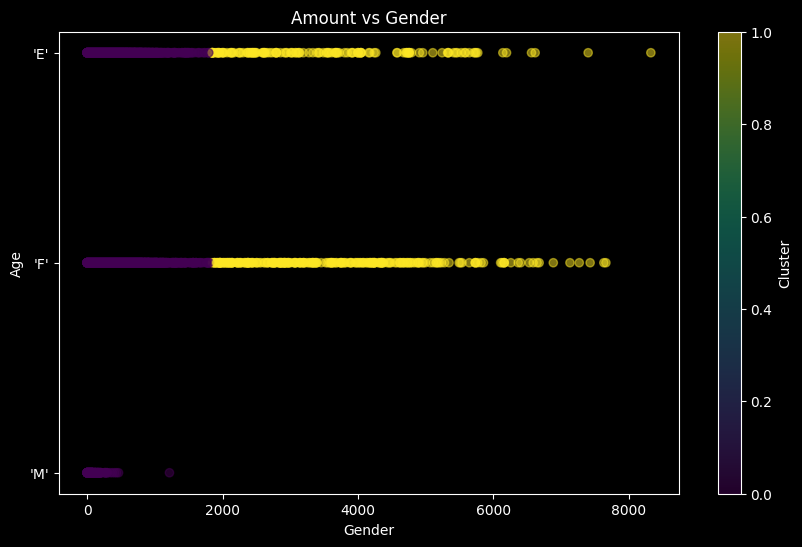

In [26]:
# plot amount vs gender with clusters
plt.figure(figsize=(10, 6))
plt.scatter(df['amount'], df['gender_original_enum'], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.title('Amount vs Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.yticks(range(len(df['gender_original'].unique())), df['gender_original'].unique())
plt.colorbar(label='Cluster')
plt.show()

Plotting, using PCA components

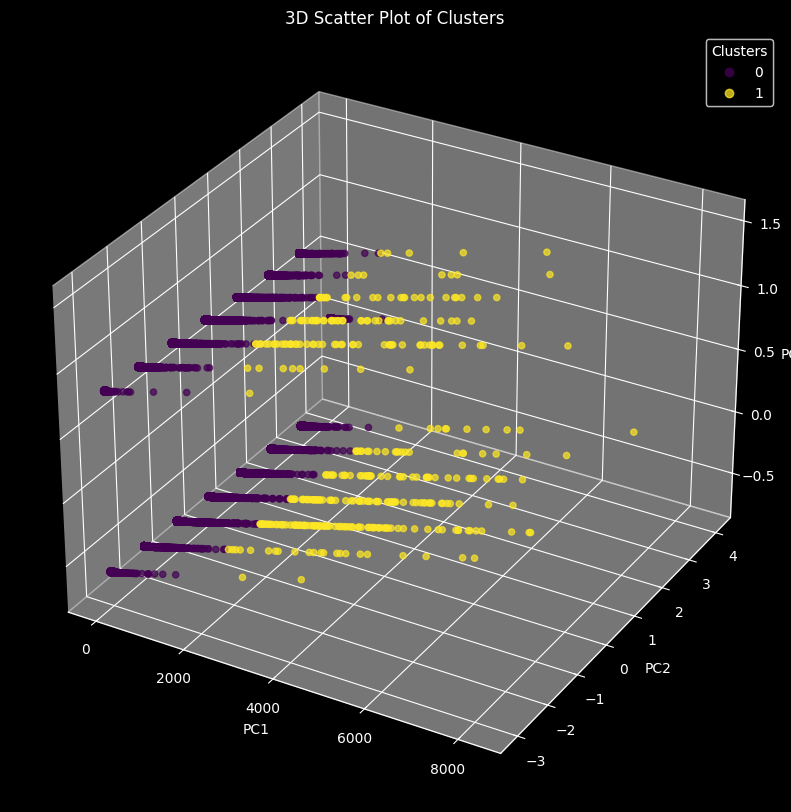

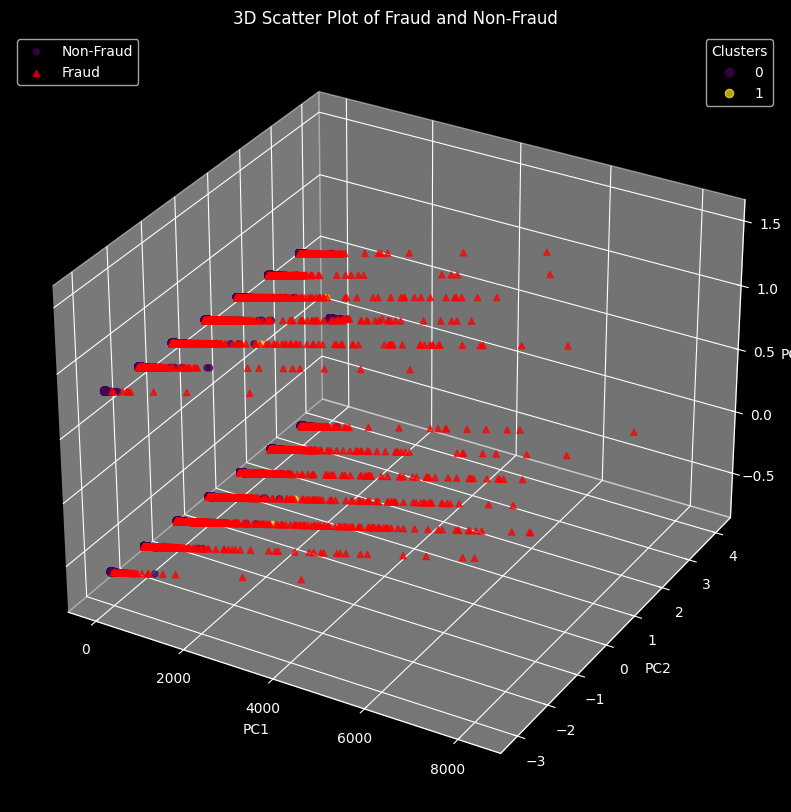

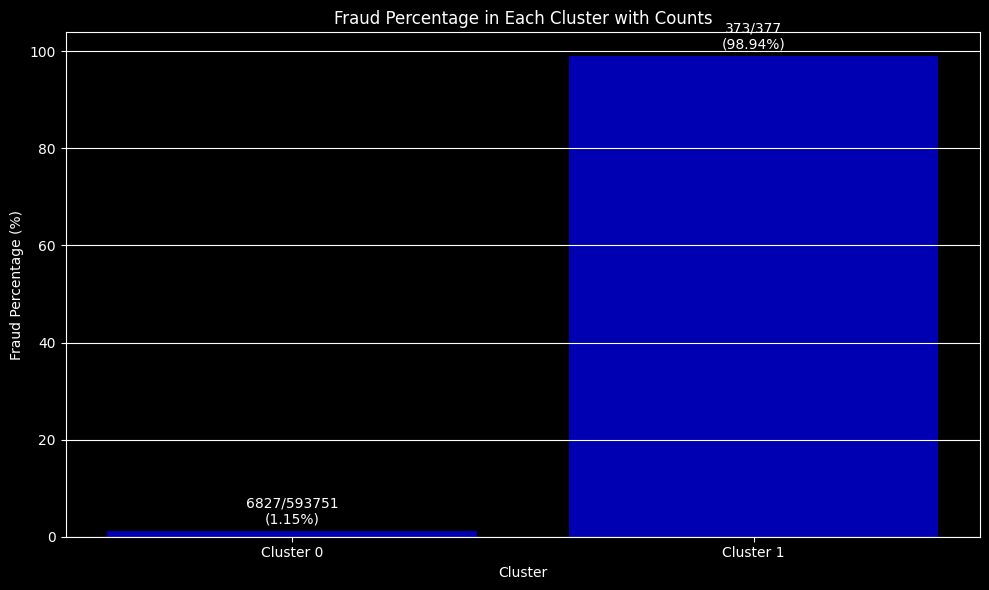

In [29]:
plot_results(df_pca)

## 3 clusters

In [30]:
y_pred = KMeans(n_clusters=3, n_init='auto').fit_predict(X)
#overwrite the cluster column in df_pca with the new cluster labels
df_pca['cluster'] = y_pred
df['cluster'] = y_pred

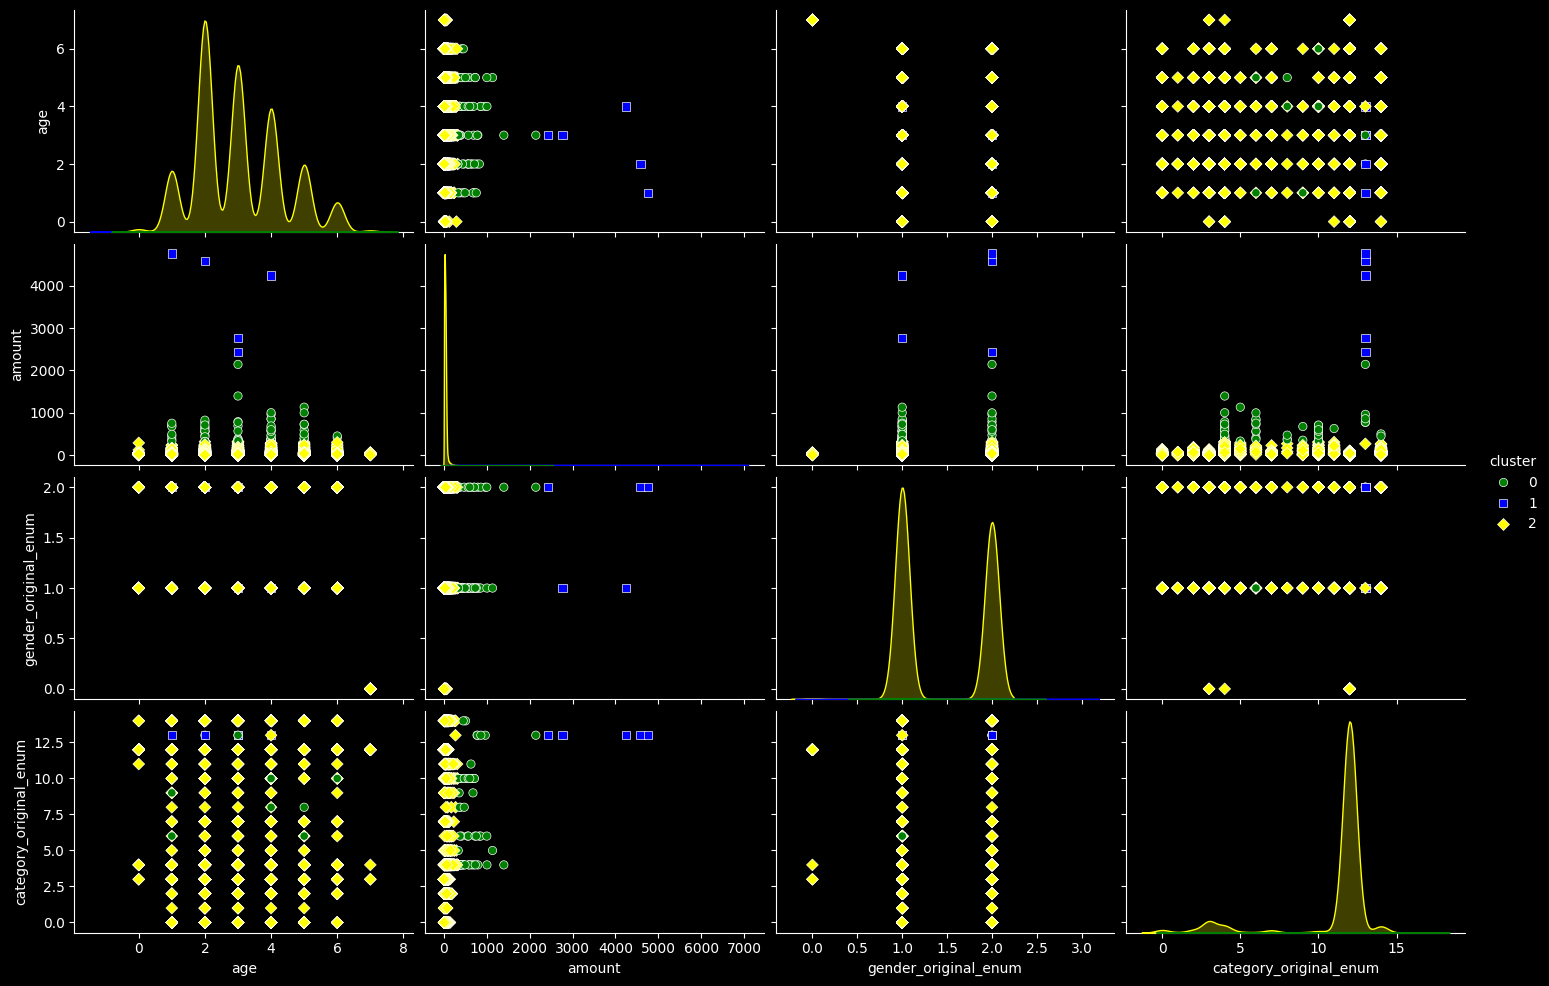

In [31]:
one_hot_col_names = [col for col in df.columns if (col.startswith('gender_') or col.startswith('category_')) and not col.endswith('original_enum')]
sns.pairplot(df.drop(columns=['fraud'] + one_hot_col_names).sample(10000), hue='cluster', palette=['green', 'blue', 'yellow'], diag_kind='kde', markers=['o', 's', 'D'], height=2.5, aspect=1.5)
plt.show()

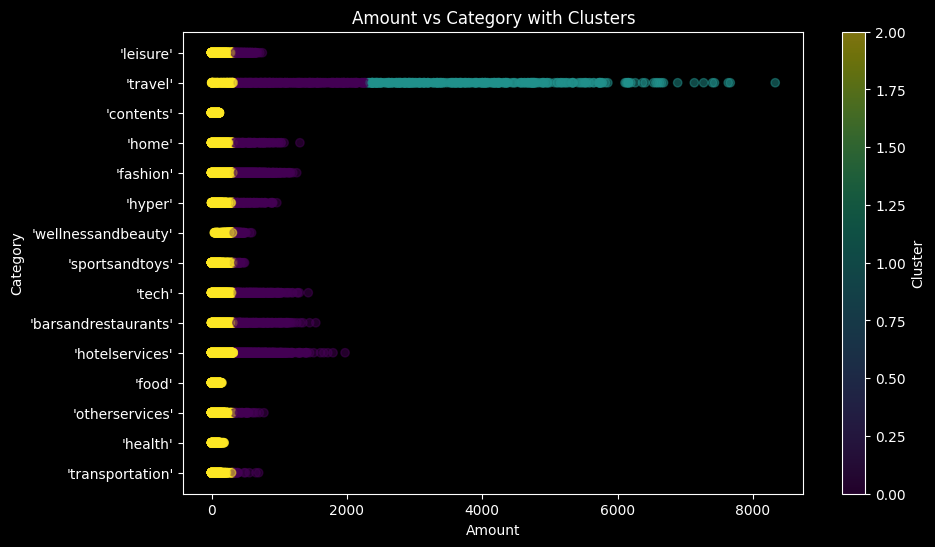

In [33]:
#plot amount vs category with clusters 
plt.figure(figsize=(10, 6))
plt.scatter(df['amount'], df['category_original_enum'], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.title('Amount vs Category with Clusters')
plt.xlabel('Amount')
plt.ylabel('Category')
plt.yticks(range(len(df['category_original'].unique())), df['category_original'].unique())
plt.colorbar(label='Cluster')
plt.show()

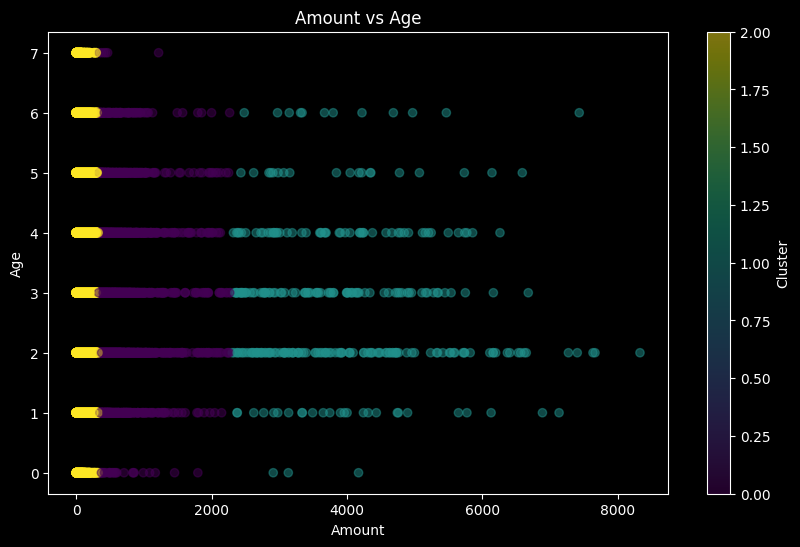

In [32]:
# plot amount vs age with clusters
plt.figure(figsize=(10, 6))
plt.scatter(df['amount'], df['age'], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.title('Amount vs Age')
plt.xlabel('Amount')
plt.ylabel('Age')
plt.colorbar(label='Cluster')
plt.show()

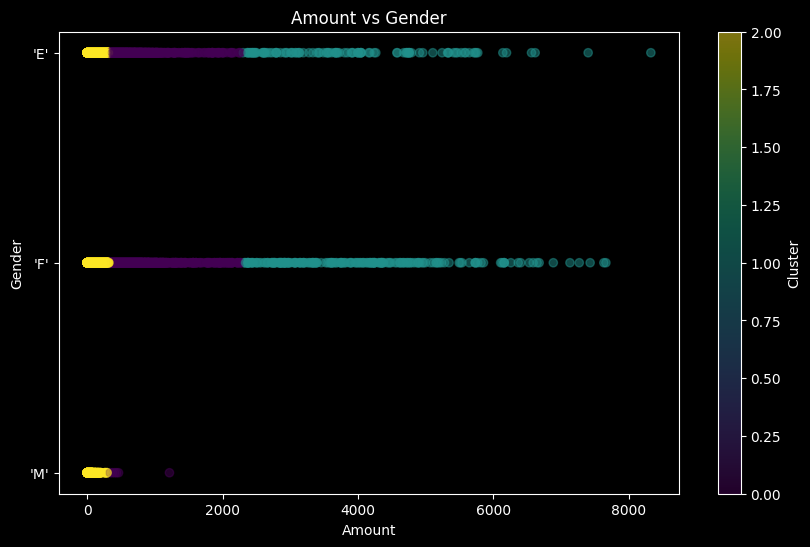

In [35]:
# plot amount vs gender with clusters
plt.figure(figsize=(10, 6))
plt.scatter(df['amount'], df['gender_original_enum'], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.title('Amount vs Gender')
plt.xlabel('Amount')
plt.ylabel('Gender')
plt.yticks(range(len(df['gender_original'].unique())), df['gender_original'].unique())
plt.colorbar(label='Cluster')
plt.show()

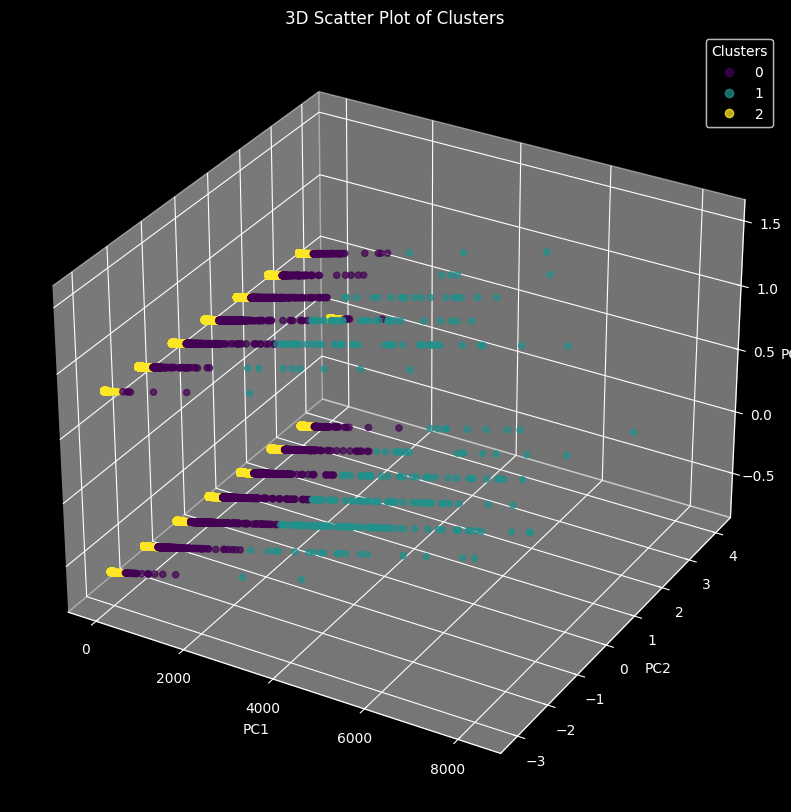

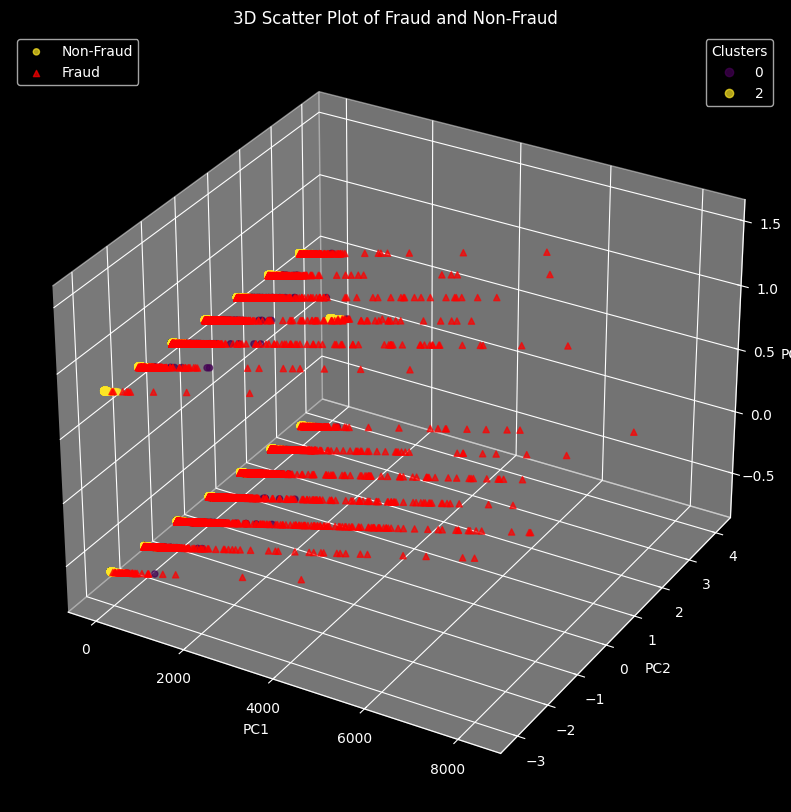

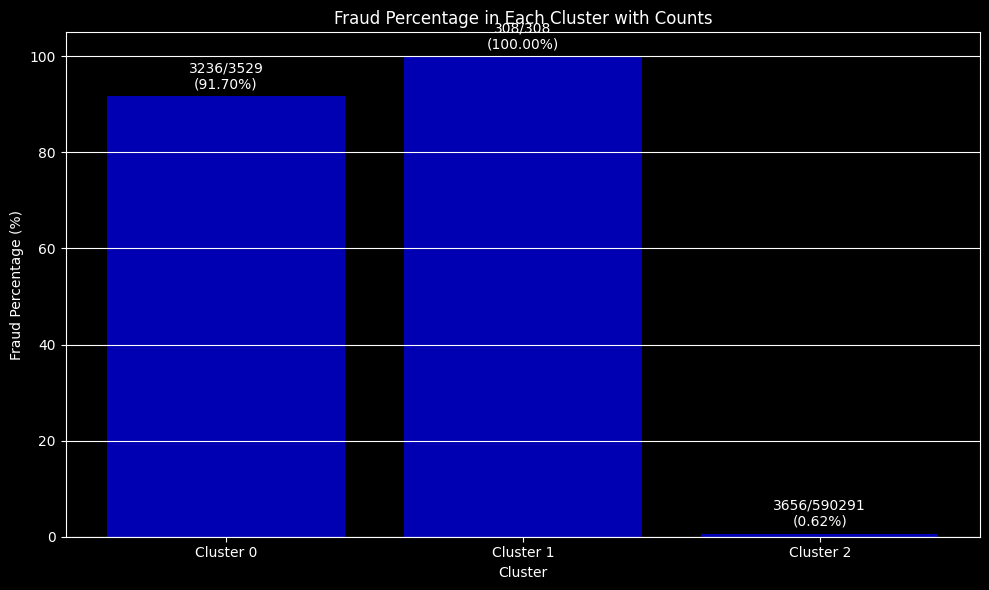

In [36]:
plot_results(df_pca)

# 5. Final Thoughs

- We can see that `ammount` is the most significant factor for the clustering.
- The 2 classes do quite a good job of spliting the data into a 'fraud' and 'non-fraud' cluster but they obviously have some errors.
- The 3 clusters seperate the data into 3 categories that I would label as "not fraud", "possibly fraud" "100% fraud".